$$\require{mhchem}$$       

# Non-isothermal batch reactor design

The exothermic elementary liquid phase reaction
\begin{align}
\ce{A + B <->[k,K] C + D}\\
\end{align}
is carried out in a batch reactor with a cooling coil to keep the reactor isothermal at 40 C. The reactor is initially charged with equal concentrations of A and B and no C or D, $C_{A0}=C_{B0}=2$mol/L.  

$k=0.1$ L/mol/min at 40 C, $K=2$ at 40 C

$\Delta H_R=-20$ kcal/mol A at 40 C

Partial molar heat capacities $C_{pA}=C_{pB}=C_{pC}=C_{pD}=20$cal/mol/K

Activation energy for the reaction $E_a=1000 cal/mol/K$. 

Reactor volume 1200 L

#### How long does it take to reach 50% conversion? Also show a plot of concentration of all species vs time.

It will take 6.23 mins to reach 50% conversion.


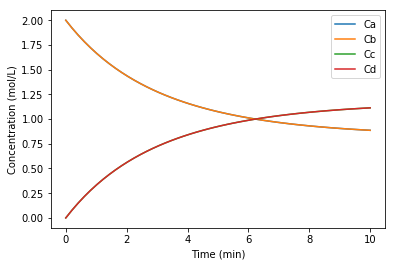

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Reactor isothermal at 40 C

Ca0 = 2        # mol/L
Cb0 = 2        # mol/L

k = 0.1        # L/mol/min at 40C
K = 2          # at 40C
k_ = k/K       # at 40C
dHr = -20      # kcal/mol at 40C

cpa = cpb = cpc = cpd = 20e-3    # kcal/mol/K
Ea = 1         # kcal/mol/K

V = 1200       # L

def batch(C, t):
    Ca, Cb, Cc, Cd = C
    
    r = k * Ca * Cb - k_ * Cc * Cd
    
    dCadt = -r
    dCbdt = -r
    dCcdt = r
    dCddt = r
    
    return [dCadt, dCbdt, dCcdt, dCddt]

def conversion(t):
    tspan = np.linspace(0, t)
    C0 = [Ca0, Cb0, 0, 0]
    
    sol = odeint(batch, C0, tspan)
    
    return sol[-1, 0] - 0.5*Ca0

t_guess = 5      # min
t_sol, = fsolve(conversion, t_guess)

print('It will take {0:0.2f} mins to reach 50% conversion.'.format(t_sol))

C0 = [Ca0, Cb0, 0, 0]
tspan = np.linspace(0, 10)
sol_C = odeint(batch, C0, tspan)

plt.plot(tspan, sol_C)
plt.legend(['Ca', 'Cb', 'Cc', 'Cd'])
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mol/L)')
plt.show()

#### What is the total amount of heat (kcal) that must be removed by the cooling coil when the conversion is reached?

The total amount of heat that must be removed when 50% conversion is reached is 24000.00 kcal.


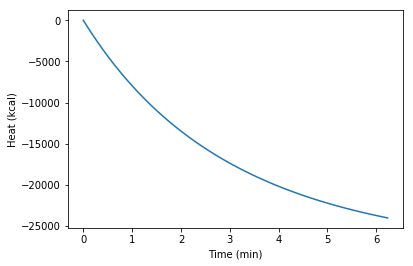

In [2]:
# 0 = -dHr * r * V + dQdt

def cooling(Y, t):
    Ca, Cb, Cc, Cd, Q = Y
    
    r = k * Ca * Cb - k_ * Cc * Cd
    
    dCadt = -r
    dCbdt = -r
    dCcdt = r
    dCddt = r
    dQdt = dHr * r * V
    
    return [dCadt, dCbdt, dCcdt, dCddt, dQdt]

tspan_conv = np.linspace(0, t_sol)
Y0 = [Ca0, Cb0, 0, 0, 0]
sol_CQ = odeint(cooling, Y0, tspan_conv)
Q_remove = abs(sol_CQ[-1, -1])

print('The total amount of heat that must be removed when 50% conversion is reached is {0:0.2f} kcal.'.format(Q_remove))
plt.plot(tspan_conv, sol_CQ[:, -1])
plt.xlabel('Time (min)')
plt.ylabel('Heat (kcal)')
plt.show()

#### What is the maximum rate at which heat must be removed by the cooling coil, and at what time does this occur?

The rate of heat that must be removed by cooling coil is:

\begin{equation}
\frac{dQ}{dt} = dH_r r V
\end{equation}

In this problem, $dH_r$ and $V$ are constant, so $\frac{dQ}{dt}$ maximizes when $r$ maximizes:

\begin{equation}
r = K C_a C_b - C_c C_d
\end{equation}

Obviously, $r$ maximizes at initial time when $C_a$ $C_b$ maximize and $C_c$ $C_d$ minimize.

The maximum rate of heat that must be removed by cooling coil is 9600.00 kcal/min.


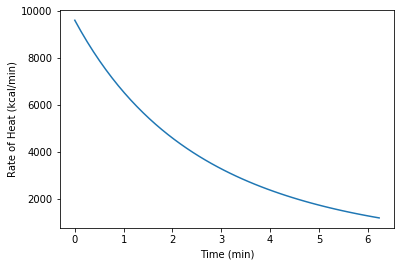

In [3]:
Ca = sol_CQ[:, 0]
Cb = sol_CQ[:, 1]
Cc = sol_CQ[:, 2]
Cd = sol_CQ[:, 3]

r = k * Ca * Cb - k_ * Cc * Cd
dQdt = abs(dHr * r * V)
dQdt_max = max(dQdt)

print('The maximum rate of heat that must be removed by cooling coil is {0:0.2f} kcal/min.'.format(dQdt_max))

plt.plot(tspan_conv, dQdt)
plt.xlabel('Time (min)')
plt.ylabel('Rate of Heat (kcal/min)')
plt.show()

#### Now consider a non-isothermal version of this reactor.  There is a cooling bath around the reactor with a total heat transfer coefficient $Ua=300$ kcal/L/min. The reactor starts at 40 C  What is the maximum temperature $T_0$ that you can keep the cooling bath such that the temperature in the batch reactor rises no higher than 60C?



In [4]:
T0 = 273.15+40      # K 
Ua = 300            # kcal/L/min

R = 1.987e-3        # kcal/K/mol

def noniso(Y, t, Tcool):
    Ca, Cb, Cc, Cd, T = Y
    
    na = Ca * V
    nb = Cb * V
    nc = Cc * V
    nd = Cd * V
    
    kt = k * np.exp(-Ea/R * (1.0/T - 1.0/T0))
    Kt = K * np.exp(-dHr/R * (1.0/T - 1.0/T0))
    
    kt_ = kt / Kt
    
    r = kt * Ca * Cb - kt_ * Cc * Cd
    
    Qdot = Ua * (Tcool - T)
    
    dCadt = -r
    dCbdt = -r
    dCcdt = r
    dCddt = r
    dTdt = (-dHr*r*V + Qdot) / (na*cpa + nb*cpb + nc*cpc + nd*cpd)
    
    return [dCadt, dCbdt, dCcdt, dCddt, dTdt]


def objective(Tcool):
    Y0 = [Ca0, Cb0, 0, 0, T0]
    tspan_T = np.linspace(0, 20, 1000)
    
    sol_CT = odeint(noniso, Y0, tspan_T, args=(Tcool,))
    
    Tmax = max(sol_CT[:, -1])
    
    return Tmax - (273.15+60)

Tcool_guess = 273.15+40      # K
Tcool_sol, = fsolve(objective, Tcool_guess)

print('The maximum temperature that we can keep the cooling bath is {0:0.2f}C.'.format(Tcool_sol-273.15))

The maximum temperature that we can keep the cooling bath is 34.56C.


# PBR with internal mass transfer and heat drops

You have a isomerization catalytic reactor with the following kinetics:
\begin{align*}
\ce{A + S <->[K_A] AS}\\
\ce{AS ->[k] BS}\\
\ce{BS -> B + S}
\end{align*}
The surface step is limiting and you derive the following rate law:
\begin{align*}
r= k \overline{c}_m \frac{K_A c_A}{1 + K_A c_A}
\end{align*}
The reactor is a 500 L CSTR with 5 kg of catalyst particles.  The catalyst particles are 20 mm diameter, the rate constant for the surface step is 100/s/g$_{cat}$, the activation energy for the surface step is $20$ kcal/mol, the heat of reaction for the first adsorption step is $\Delta H_R=-5$kcal/mol (assume temperature independent), the heat of reaction for the full reaction \ce{A->B} is +5 kcal/mol, and the equilibrium coefficient at 200 C is 2. The specific heat of A and B are both 10 cal/molK. The diffusion coefficient at 200 C for A in the particle is 0.1 cm$^2/s$ at 200 C and scales with temperature as $D=D_0(T/T0)^{3/2}$. The pressure drop in the reactor is negligible. The reactor is fed with $4 mol/L$ A at 1 L/s at 200 C. The catalyst site density is $C_m=10^{-2}$ mol/gcat. The reactor is adiabatic (no heat transfer). 

You may assume that the solution for a sphere applies $ \eta = \frac{1}{\Phi}  \left [\frac{1}{\tanh 3 \Phi} - \frac{1}{3 \Phi} \right]$, using the correct $\Phi$ for this problem / rate law.

#### Calculate the exit concentration of the CSTR for an inlet feed at 200 C

#### Calculate the exit concentration as a function of temperature of the inlet feed